# Classification task

ref: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

## Import and Process Data

In [1]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)

In [2]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

In [3]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [4]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

## Prepare Datasets

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1950, 150, 150, 3)


(150, 150, 3)


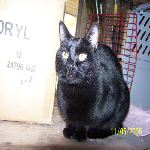

In [8]:
# Scale value from [0, 255] to [0, 1]
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [9]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


## Create CNN Model

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [12]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1950 samples
Epoch 1/30
3000/3000 [==============================] - 13s 4ms/sample - loss: 0.8043 - accuracy: 0.5737 - val_loss: 0.6551 - val_accuracy: 0.6210
Epoch 2/30
3000/3000 [==============================] - 9s 3ms/sample - loss: 0.6303 - accuracy: 0.6467 - val_loss: 0.5908 - val_accuracy: 0.6805
Epoch 3/30
3000/3000 [==============================] - 22s 7ms/sample - loss: 0.5630 - accuracy: 0.7163 - val_loss: 0.5575 - val_accuracy: 0.7154
Epoch 4/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.5087 - accuracy: 0.7560 - val_loss: 0.5604 - val_accuracy: 0.7251
Epoch 5/30
3000/3000 [==============================] - 69s 23ms/sample - loss: 0.4286 - accuracy: 0.8023 - val_loss: 0.6096 - val_accuracy: 0.7169
Epoch 6/30
3000/3000 [==============================] - 55s 18ms/sample - loss: 0.3774 - accuracy: 0.8290 - val_loss: 0.5681 - val_accuracy: 0.7138
Epoch 7/30
3000/3000 [==============================] - 64s 21ms/sam

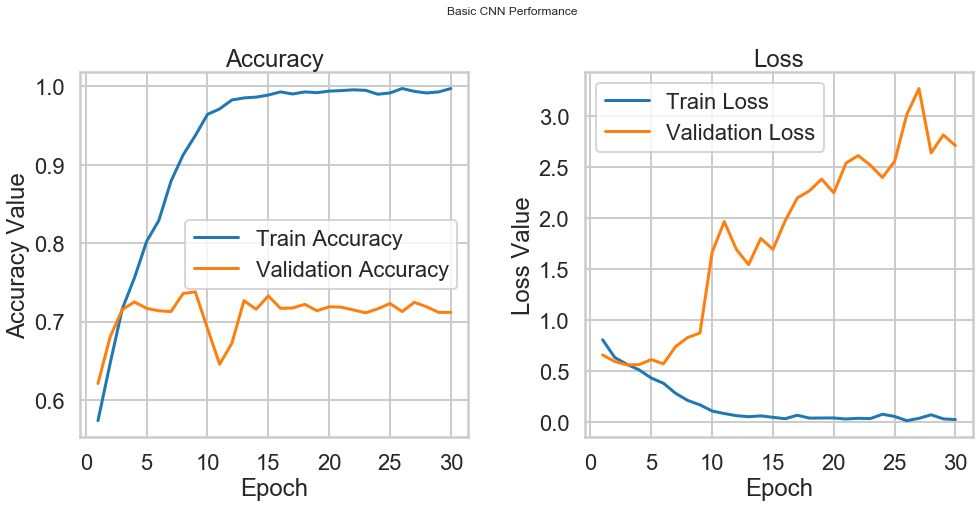

In [26]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), )
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Create CNN Model with regularizaton

In [27]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

In [28]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)         

Train on 3000 samples, validate on 1950 samples
Epoch 1/30
3000/3000 [==============================] - 16s 5ms/sample - loss: 0.7129 - accuracy: 0.5033 - val_loss: 0.6928 - val_accuracy: 0.5026
Epoch 2/30
3000/3000 [==============================] - 16s 5ms/sample - loss: 0.6889 - accuracy: 0.5370 - val_loss: 0.6882 - val_accuracy: 0.5210
Epoch 3/30
3000/3000 [==============================] - 15s 5ms/sample - loss: 0.6881 - accuracy: 0.5917 - val_loss: 0.6646 - val_accuracy: 0.5959
Epoch 4/30
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.6471 - accuracy: 0.6190 - val_loss: 0.6145 - val_accuracy: 0.6626
Epoch 5/30
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.6167 - accuracy: 0.6710 - val_loss: 0.5892 - val_accuracy: 0.6944
Epoch 6/30
3000/3000 [==============================] - 13s 4ms/sample - loss: 0.5701 - accuracy: 0.7080 - val_loss: 0.5887 - val_accuracy: 0.6892
Epoch 7/30
3000/3000 [==============================] - 16s 5ms/sample

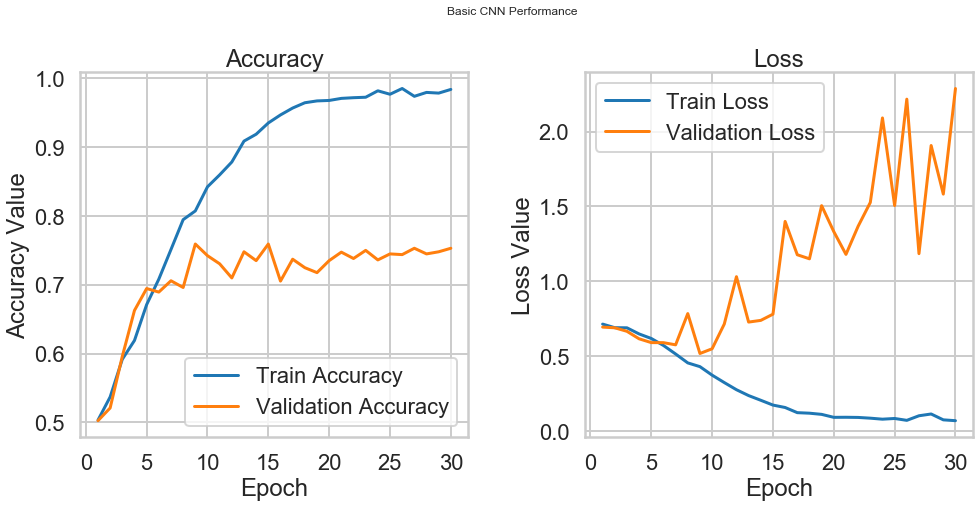

In [29]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), )
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
model.save("cats_dogs_basic_cnn.h5")

## CNN Model with Image Augmentation